In [1]:
import geopandas as gpd
import numpy as np
#import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.cm as colormaps
from matplotlib.contour import ContourSet
import re
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

In [2]:
regiones = gpd.read_file(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp')
print(regiones.columns)

Index(['Aquifer', 'Broader', 'Details', 'line_width', 'geometry'], dtype='object')


In [3]:
npfile = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheil_DTW.npz')
print(npfile.files)

['dtw_syr', 'dtw_condyr', 'dtw_s_nmax_yr', 'dtw_nmax_yr', 'dtw_vyr', 'dtw_tyr', 'dtw_resyr', 'HydroID', 'lat', 'lon', 'dtw_interc_t', 'dtw_slop_t']


In [4]:
dtw_syr       = npfile.f.dtw_syr
dtw_condyr    = npfile.f.dtw_condyr
dtw_s_nmax_yr = npfile.f.dtw_s_nmax_yr
dtw_nmax_yr   = npfile.f.dtw_nmax_yr
dtw_tyr       = npfile.f.dtw_tyr
dtw_vyr       = npfile.f.dtw_vyr
dtw_resyr     = npfile.f.dtw_resyr
HydroID       = npfile.f.HydroID
lat           = npfile.f.lat
lon           = npfile.f.lon
dtw_interc_t  = npfile.f.dtw_interc_t
dtw_slop_t    = npfile.f.dtw_slop_t

C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_12464\1048927525.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mapa['area'] = mapa.geometry.area
C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_12464\1048927525.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroides = mapa.dissolve(by='Broader').centroid


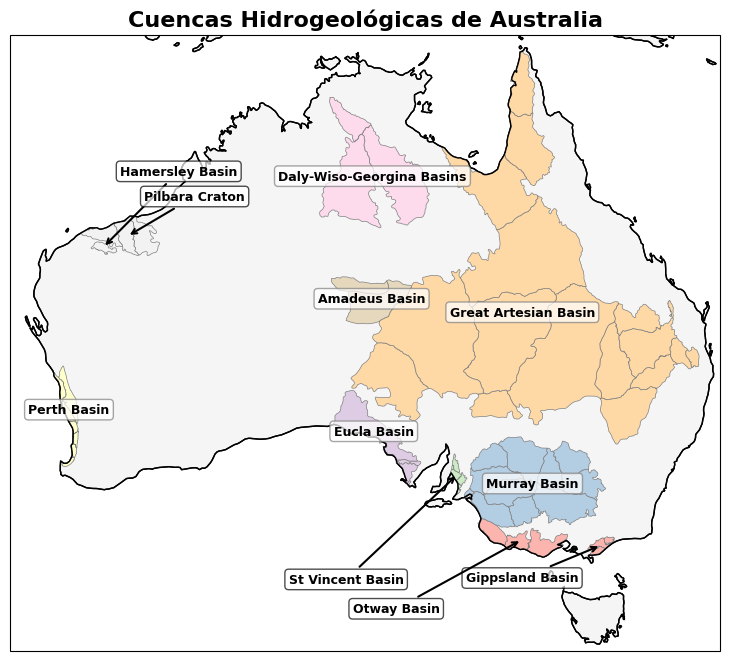

In [5]:
def vis_cuencas_hidrogeologicas(shp_path, output_path):
    # Cargar el shapefile de acuíferos
    mapa = gpd.read_file(shp_path).to_crs(epsg=4326)

    # Filtrar las cuencas válidas (remover las que tienen '-')
    mapa = mapa[mapa['Broader'] != '-']

    # Calcular el área de cada cuenca y determinar cuáles son pequeñas
    mapa['area'] = mapa.geometry.area
    small_threshold = mapa['area'].quantile(0.2)  # Cuencas en el 20% más pequeño
    small_cuencas = mapa[mapa['area'] < small_threshold]
    large_cuencas = mapa[mapa['area'] >= small_threshold]

    # Obtener un solo centroide por cuenca
    centroides = mapa.dissolve(by='Broader').centroid

    # Lista de cuencas cuyos labels deben ir fuera del mapa
    cuencas_fuera = [
        "Pilbara Craton", "Hamersley Basin",
        "St Vincent Basin", "Otway Basin", "Gippsland Basin"
    ]

    # Crear la figura con Cartopy
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())

    # Agregar el contorno de Australia
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='whitesmoke', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8, edgecolor='gray')

    # Generar colores para las cuencas usando la paleta Pastel1
    unique_regions = mapa['Broader'].unique()
    cmap = plt.get_cmap('Pastel1')  # Colores suaves
    region_colors = {region: cmap(i / (len(unique_regions)-1)) for i, region in enumerate(unique_regions)}

    # Dibujar las cuencas hidrogeológicas
    for region, color in region_colors.items():
        subset = mapa[mapa['Broader'] == region]
        subset.plot(ax=ax, color=color, edgecolor='gray', linewidth=0.5, transform=ccrs.PlateCarree())

    # Colocar labels dentro del mapa (para cuencas grandes que no deben moverse)
    for region, point in centroides.items():
        if region in large_cuencas['Broader'].values and region not in cuencas_fuera:
            ax.text(point.x, point.y, region, fontsize=9, ha='center', va='center', fontweight='bold',
                    transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))

    # Ajustar posiciones de etiquetas fuera del mapa
    offsets = {
        "Pilbara Craton": (1, 2),
        "Hamersley Basin": (1, 4),
        "St Vincent Basin": (-10, -6),  
        "Otway Basin": (-10, -4),
        "Gippsland Basin": (-8, -2)
    }

    # Colocar labels fuera del mapa con flechas ajustadas
    for region, point in centroides.items():
        if region in cuencas_fuera:
            x_offset, y_offset = offsets.get(region, (5, 5))
            ax.annotate(region, xy=(point.x, point.y), xytext=(point.x + x_offset, point.y + y_offset),
                        fontsize=9, fontweight='bold', color='black',
                        arrowprops=dict(arrowstyle="->", lw=1.5, color='black'),
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'),
                        transform=ccrs.PlateCarree())

    ax.set_title('Cuencas Hidrogeológicas de Australia', fontsize=16, fontweight='bold')
    plt.subplots_adjust(right=1)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Ruta del shapefile de acuíferos
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp'

# Ruta para guardar la imagen
output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\cuencas_hidrogeologicas.png'

# Llamar a la función
vis_cuencas_hidrogeologicas(shp_path, output_path)

Figura guardada en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\mapa_pozos_y_cuencas.png


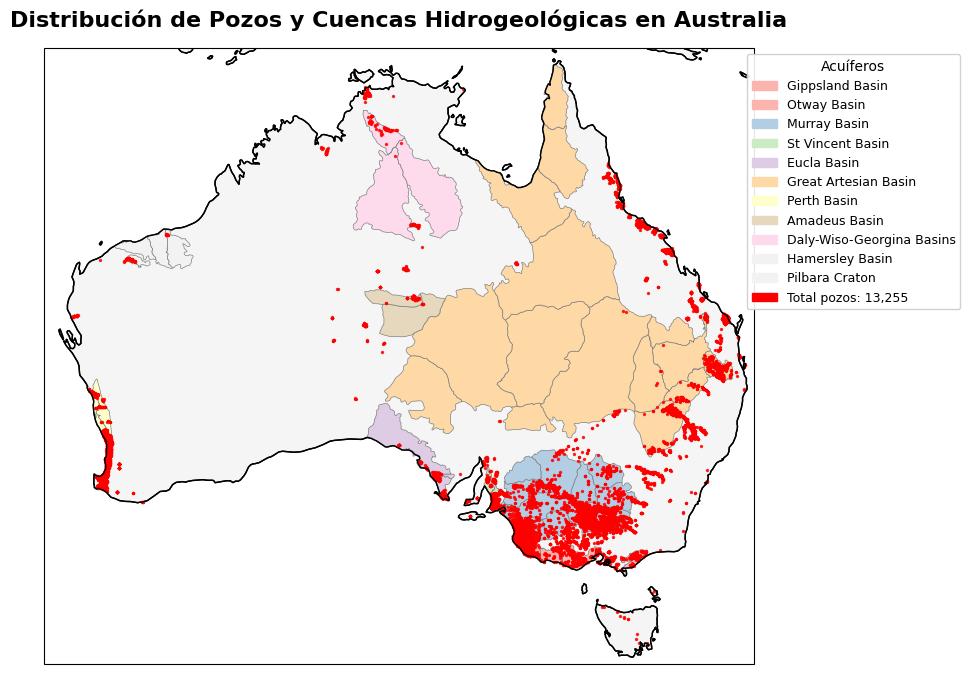

In [6]:
def vis_cuencas_y_pozos(shp_path, npz_paths, output_path):
    # Cargar el shapefile de acuíferos y proyectarlo a un CRS adecuado
    mapa = gpd.read_file(shp_path).to_crs(epsg=3577)  # CRS adecuado para Australia (GDA94 / Australian Albers)

    # Filtrar las cuencas válidas (remover las que tienen '-')
    mapa = mapa[mapa['Broader'] != '-']

    # Calcular áreas correctamente en un CRS proyectado
    mapa['area'] = mapa.geometry.area

    # Volver a EPSG:4326 para graficar en Cartopy
    mapa = mapa.to_crs(epsg=4326)

    # Cargar datos de pozos desde archivos .npz
    all_lon, all_lat = [], []
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        all_lon.append(pozos['lon'][mask])
        all_lat.append(pozos['lat'][mask])

    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)
    total_pozos = len(lon)

    # Crear la figura con Cartopy
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())

    # Agregar el contorno de Australia
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='whitesmoke', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8, edgecolor='gray')

    # Generar colores para las cuencas usando la paleta Pastel1
    unique_regions = mapa['Broader'].unique()
    cmap = plt.get_cmap('Pastel1')  # Colores suaves
    region_colors = {region: cmap(i / (len(unique_regions)-1)) for i, region in enumerate(unique_regions)}

    # Dibujar las cuencas hidrogeológicas
    for region, color in region_colors.items():
        subset = mapa[mapa['Broader'] == region]
        subset.plot(ax=ax, color=color, edgecolor='gray', linewidth=0.5, transform=ccrs.PlateCarree())

    # Graficar los pozos en rojo
    ax.scatter(lon, lat, color='red', marker='.', s=8, alpha=0.8, transform=ccrs.PlateCarree())

    # Agregar título
    ax.set_title("Distribución de Pozos y Cuencas Hidrogeológicas en Australia", fontsize=16, fontweight='bold', pad=15)

    # Crear una leyenda mejor estructurada
    region_patches = [mpatches.Patch(color=color, label=region) for region, color in region_colors.items()]
    legend_pozos = mpatches.Patch(color='red', label=f'Total pozos: {total_pozos:,}')

    # Insertar la leyenda en un cuadro con fondo semitransparente
    legend = ax.legend(handles=region_patches + [legend_pozos], loc='upper right', bbox_to_anchor=(1.3, 1),
                       fontsize=9, title="Acuíferos", frameon=True)
    legend.get_frame().set_alpha(0.9)  # Hacer la leyenda semi-transparente

    # Guardar la imagen con buena calidad
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figura guardada en: {output_path}")

    plt.show()

# Ruta del shapefile de acuíferos
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp'

# Rutas de archivos NPZ con pozos
npz_paths = [
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen\satheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheil_DTW.npz'
]

# Ruta para guardar la imagen
output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\mapa_pozos_y_cuencas.png'

# Llamar a la función
vis_cuencas_y_pozos(shp_path, npz_paths, output_path)

ValueError: 'data' should be a 1-dimensional array of geometry objects.

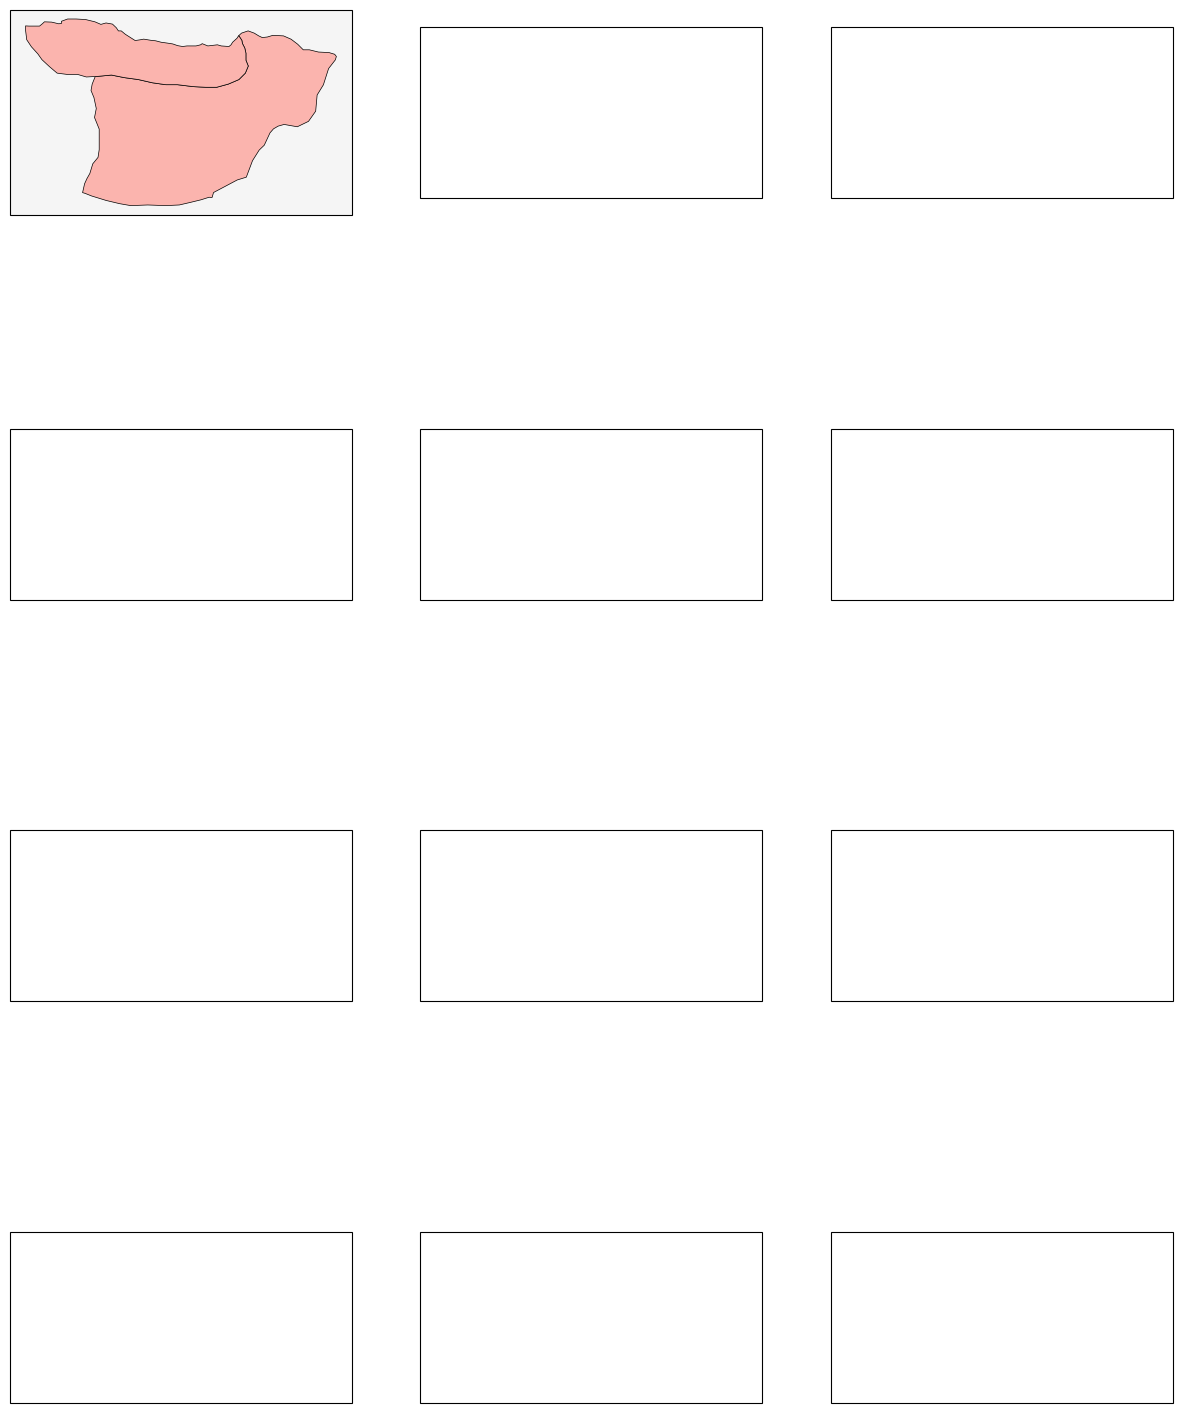

In [7]:
##### Graficar cada cuenca por aparte con el total de pozos pero todas en una misma imágen.
def vis_cuencas_separadas(shp_path, npz_paths, output_path):
    # Cargar el shapefile de acuíferos y proyectarlo a EPSG:4326
    mapa = gpd.read_file(shp_path).to_crs(epsg=4326)

    # Filtrar las cuencas válidas (remover las que tienen '-')
    mapa = mapa[mapa['Broader'] != '-']

    # Obtener la lista de cuencas únicas
    unique_regions = sorted(mapa['Broader'].unique())
    num_cuencas = len(unique_regions)

    # Calcular el número de filas y columnas para los subplots
    cols = 3  # Número fijo de columnas
    rows = int(np.ceil(num_cuencas / cols))

    # Cargar datos de pozos desde archivos .npz
    all_pozos = []
    for npz_path in npz_paths:
        try:
            pozos = np.load(npz_path)
            mask = pozos['dtw_condyr'] == 1
            lon = pozos['lon'][mask]
            lat = pozos['lat'][mask]
            if len(lon) > 0 and len(lat) > 0:
                all_pozos.append((lon, lat))
            else:
                all_pozos.append((np.array([]), np.array([])))  # Si está vacío, añadir array vacío
        except Exception as e:
            print(f"Error al cargar {npz_path}: {e}")
            all_pozos.append((np.array([]), np.array([])))  # Agregar lista vacía si hay error

    # Crear la figura con subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # Generar colores para las cuencas usando la paleta Pastel1
    cmap = plt.get_cmap('Pastel1')
    region_colors = {region: cmap(i / (num_cuencas - 1)) for i, region in enumerate(unique_regions)}

    # Dibujar cada cuenca en un subplot
    for i, (region, ax) in enumerate(zip(unique_regions, axes)):
        subset = mapa[mapa['Broader'] == region]

        # Graficar el contorno de Australia
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='whitesmoke', linewidth=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8, edgecolor='gray')

        # Dibujar la cuenca en su color correspondiente
        subset.plot(ax=ax, color=region_colors[region], edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

        # Graficar solo los pozos dentro de la cuenca
        lon_all, lat_all = [], []
        for lon, lat in all_pozos:
            if lon.size > 0 and lat.size > 0:  # Asegurar que no esté vacío
                points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon, lat), crs="EPSG:4326")
                points_in_cuenca = points[points.within(subset.unary_union)]
                lon_all.extend(points_in_cuenca.geometry.x)
                lat_all.extend(points_in_cuenca.geometry.y)

        # Si hay pozos, graficarlos
        if len(lon_all) > 0 and len(lat_all) > 0:
            ax.scatter(lon_all, lat_all, color='red', marker='.', s=8, alpha=0.8, transform=ccrs.PlateCarree())

        # Título con el nombre de la cuenca
        ax.set_title(region, fontsize=12, fontweight='bold')

    # Ajustar diseño eliminando subplots vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figura guardada en: {output_path}")

    plt.show()

# Ruta del shapefile de acuíferos
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp'

# Rutas de archivos NPZ con pozos
npz_paths = [
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen\satheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheil_DTW.npz'
]

# Ruta para guardar la imagen
output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\mapa_cuencas_separadas.png'

# Llamar a la función
vis_cuencas_separadas(shp_path, npz_paths, output_path)

CRS del shapefile: EPSG:4326
Región: Murray Basin, Pozos: 4417


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Mi unidad\\Maestria\\Proyecto de Grado\\analisis_nf\\datos\\australia\\images/DTWbasin_Murray_Basin.png'

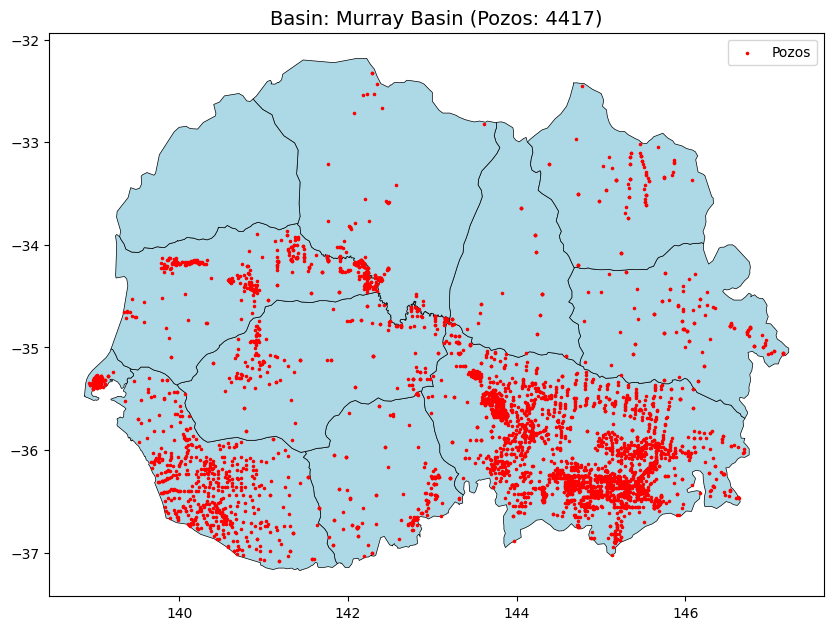

In [8]:
def vis_pozos_por_region(shp_path, npz_paths, output_folder):
    # Cargar shapefile y verificar proyección
    mapa = gpd.read_file(shp_path)
    if mapa.crs is None:
        raise ValueError("El shapefile no tiene un sistema de coordenadas definido.")
    print(f"CRS del shapefile: {mapa.crs}")
    
    # Listas para almacenar coordenadas de todos los pozos
    all_lon = []
    all_lat = []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        if 'lon' not in pozos or 'lat' not in pozos or 'dtw_condyr' not in pozos:
            raise ValueError(f"El archivo {npz_path} no contiene las claves necesarias ('lon', 'lat', 'dtw_condyr').")
        
        # Filtrar pozos válidos
        mask = pozos['dtw_condyr'] == 1
        all_lon.append(pozos['lon'][mask])
        all_lat.append(pozos['lat'][mask])

    # Combinar todas las coordenadas de pozos
    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)

    # Crear un GeoDataFrame para los pozos
    pozos_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(lon, lat)], crs="EPSG:4326")
    if pozos_gdf.crs != mapa.crs:
        pozos_gdf = pozos_gdf.to_crs(mapa.crs)

    # Intersección espacial para asignar pozos a regiones
    pozos_asignados = gpd.sjoin(pozos_gdf, mapa, how='inner', predicate='intersects')

    # Contar pozos por región
    pozos_por_region = pozos_asignados['Broader'].value_counts()

    # Graficar un zoom por cada región con pozos
    for region, count in pozos_por_region.items():
        print(f'Región: {region}, Pozos: {count}')
        
        region_geom = mapa[mapa['Broader'] == region]

    
        pozos_region = pozos_asignados[pozos_asignados['Broader'] == region]

        fig, ax = plt.subplots(figsize=(10, 8))
        region_geom.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.5)
        pozos_region.plot(ax=ax, color='red', marker='.', markersize=10, label='Pozos')

        ax.set_title(f'Basin: {region} (Pozos: {count})', fontsize=14)
        ax.legend()
        output_file = f"{output_folder}/DTWbasin_{re.sub(r'[^a-zA-Z0-9_]', '_', region)}.png"
        plt.savefig(output_file, bbox_inches='tight')
        plt.close()

# Rutas de los archivos
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp'
npz_paths = [r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheil_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheil_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheil_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen\satheil_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheil_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheil_DTW.npz',
           r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheil_DTW.npz']
    
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\images'

# Llamar a la función
vis_pozos_por_region(shp_path, npz_paths, output_folder)

Figura guardada en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\hydrogeologyDTW_theilsen.png


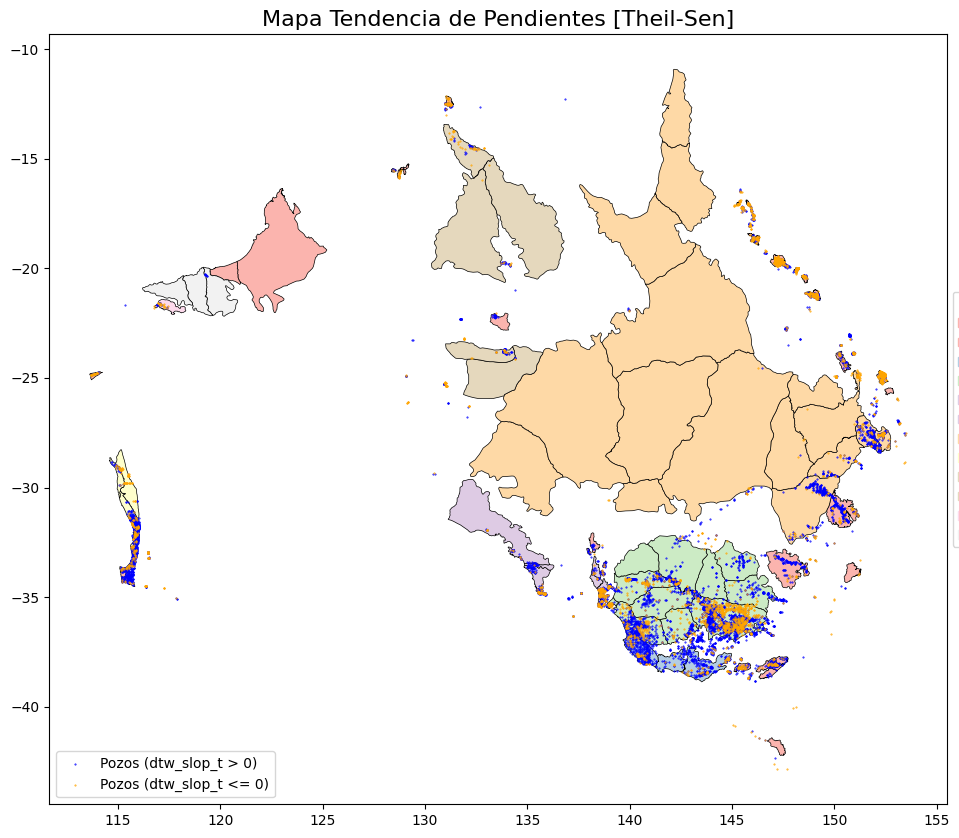

In [9]:
def vis_pozos(shp_path, npz_paths, output_path=None):
    mapa = gpd.read_file(shp_path)
    all_lon_pos = []
    all_lat_pos = []
    all_lon_neg = []
    all_lat_neg = []
    
    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        lon = pozos['lon'][mask]
        lat = pozos['lat'][mask]
        slope = pozos['dtw_slop_t'][mask]
        
        # Clasificar pozos por pendiente
        pos_mask = slope > 0
        neg_mask = slope <= 0
        all_lon_pos.append(lon[pos_mask])
        all_lat_pos.append(lat[pos_mask])
        all_lon_neg.append(lon[neg_mask])
        all_lat_neg.append(lat[neg_mask])
    
    # Concatenar los valores
    lon_pos = np.concatenate(all_lon_pos)
    lat_pos = np.concatenate(all_lat_pos)
    lon_neg = np.concatenate(all_lon_neg)
    lat_neg = np.concatenate(all_lat_neg)
    
    # Generar colores para las regiones (versión actualizada)
    unique_regions = mapa['Broader'].unique()
    cmap = plt.cm.Pastel1  # Forma actualizada de obtener el colormap
    region_colors = {region: cmap(i / len(unique_regions)) for i, region in enumerate(unique_regions)}
    
    fig, ax = plt.subplots(figsize=(15, 10))
    for region, color in region_colors.items():
        mapa[mapa['Broader'] == region].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5)
    
    # Graficar pozos
    ax.scatter(lon_pos, lat_pos, color='blue', marker='.', s=0.8, label='Pozos (dtw_slop_t > 0)')
    ax.scatter(lon_neg, lat_neg, color='orange', marker='.', s=0.8, label='Pozos (dtw_slop_t <= 0)')
    
    # Títulos y leyendas
    ax.set_title('Mapa Tendencia de Pendientes [Theil-Sen]', fontsize=16)
    region_patches = [mpatches.Patch(color=color, label=f'{region} Basin') for region, color in region_colors.items()]
    legend_pozos = ax.legend(handles=region_patches, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, title="Basin")
    ax.legend(loc='lower left', fontsize=10)
    ax.add_artist(legend_pozos)
    plt.subplots_adjust(right=0.8)
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Figura guardada en: {output_path}")
    
    plt.show()

# Rutas de entrada
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp'
npz_paths = [
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen\satheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheil_DTW.npz'
]

output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\hydrogeologyDTW_theilsen.png'
vis_pozos(shp_path, npz_paths, output_path)

In [ ]:
def vis_pozos(shp_path, npz_paths, output_path):
    # Cargar datos de acuíferos
    mapa = gpd.read_file(shp_path).to_crs(epsg=4326)

    all_lon, all_lat, all_slope = [], [], []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        lon = pozos['lon'][mask]
        lat = pozos['lat'][mask]
        slope = pozos['dtw_slop_t'][mask]

        # Filtrar por pendiente dentro del rango (-0.5, 0.5)
        valid_mask = (slope > -0.5) & (slope < 0.5)
        all_lon.append(lon[valid_mask])
        all_lat.append(lat[valid_mask])
        all_slope.append(slope[valid_mask])

    # Concatenar los valores
    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)
    slope = np.concatenate(all_slope)

    # Generar colores para las cuencas con la paleta Pastel1
    unique_regions = mapa['Broader'].unique()
    cmap = plt.get_cmap('Pastel1')  # Usar colores más suaves
    region_colors = {region: cmap(i / (len(unique_regions)-1)) for i, region in enumerate(unique_regions)}

    # Crear la figura con Cartopy
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Definir la extensión del mapa (Australia)
    ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())

    # Agregar el contorno de Australia
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='whitesmoke', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8, edgecolor='gray')

    # Dibujar los acuíferos con colores pasteles diferenciables
    for region, color in region_colors.items():
        mapa[mapa['Broader'] == region].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

    # Clasificar y graficar pozos por rangos de pendiente
    slope_colors = []
    for s in slope:
        if s < -0.1:
            slope_colors.append('red')
        elif -0.1 <= s < 0:
            slope_colors.append('orange')
        elif 0 <= s < 0.1:
            slope_colors.append('lightblue')
        else:
            slope_colors.append('darkblue')

    ax.scatter(lon, lat, color=slope_colors, marker='o', s=5, alpha=0.8, transform=ccrs.PlateCarree())

    # Título mejorado
    ax.set_title('Tendencia de Pendientes [Theil-Sen]', fontsize=16, fontweight='bold')

    # Crear leyenda de acuíferos (ubicada a la derecha)
    region_patches = [mpatches.Patch(color=color, label=region) for region, color in region_colors.items()]
    legend_pozos = ax.legend(handles=region_patches, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, title="Acuíferos")

    # Agregar la leyenda de acuíferos al gráfico antes de la segunda leyenda
    ax.add_artist(legend_pozos)

    # Leyenda para la clasificación de pozos por pendiente
    custom_legend = [
        Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=6, label='Slope < -0.1'),
        Line2D([0], [0], color='orange', marker='o', linestyle='None', markersize=6, label='-0.1 <= Slope < 0'),
        Line2D([0], [0], color='lightblue', marker='o', linestyle='None', markersize=6, label='0 <= Slope < 0.1'),
        Line2D([0], [0], color='darkblue', marker='o', linestyle='None', markersize=6, label='Slope >= 0.1')
    ]
    
    # Agregar la segunda leyenda en la parte inferior derecha
    ax.legend(handles=custom_legend, loc='lower right', fontsize=10, title="Rango de Pendientes")

    # Ajustar diseño
    plt.subplots_adjust(right=0.8)

    # Guardar la imagen en alta calidad
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def vis_pozos(shp_path, npz_paths, output_path):
    # Cargar datos de acuíferos
    mapa = gpd.read_file(shp_path).to_crs(epsg=4326)

    all_lon, all_lat, all_slope = [], [], []

    # Procesar cada archivo .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        lon = pozos['lon'][mask]
        lat = pozos['lat'][mask]
        slope = pozos['dtw_slop_t'][mask]

        # Filtrar por pendiente dentro del rango (-0.5, 0.5)
        valid_mask = (slope > -0.5) & (slope < 0.5)
        all_lon.append(lon[valid_mask])
        all_lat.append(lat[valid_mask])
        all_slope.append(slope[valid_mask])

    # Concatenar los valores
    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)
    slope = np.concatenate(all_slope)

    # Generar colores para las cuencas con la paleta Pastel1
    unique_regions = mapa['Broader'].unique()
    cmap = plt.get_cmap('Pastel1')  # Usar colores más suaves
    region_colors = {region: cmap(i / (len(unique_regions)-1)) for i, region in enumerate(unique_regions)}

    # Crear la figura con Cartopy
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Definir la extensión del mapa (Australia)
    ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())

    # Agregar el contorno de Australia
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='whitesmoke', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8, edgecolor='gray')

    # Dibujar los acuíferos con colores pasteles diferenciables
    for region, color in region_colors.items():
        mapa[mapa['Broader'] == region].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

    # Clasificar y graficar pozos por rangos de pendiente
    slope_colors = []
    for s in slope:
        if s < -0.1:
            slope_colors.append('red')
        elif -0.1 <= s < 0:
            slope_colors.append('orange')
        elif 0 <= s < 0.1:
            slope_colors.append('lightblue')
        else:
            slope_colors.append('darkblue')

    ax.scatter(lon, lat, color=slope_colors, marker='o', s=5, alpha=0.8, label='Pozos clasificados por pendiente', transform=ccrs.PlateCarree())

    # Título mejorado
    ax.set_title('Tendencia de Pendientes [Theil-Sen]', fontsize=16, fontweight='bold')

    # Crear leyenda de cuencas (ubicada a la derecha)
    region_patches = [mpatches.Patch(color=color, label=region) for region, color in region_colors.items()]
    legend_pozos = ax.legend(handles=region_patches, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, title="Acuíferos")

    # Leyenda para la clasificación de pozos por pendiente
    custom_legend = [
        Line2D([0], [0], color='red', marker='.', linestyle='None', markersize=6, label='Slope < -0.1'),
        Line2D([0], [0], color='orange', marker='.', linestyle='None', markersize=6, label='-0.1 <= Slope < 0'),
        Line2D([0], [0], color='lightblue', marker='.', linestyle='None', markersize=6, label='0 <= Slope < 0.1'),
        Line2D([0], [0], color='darkblue', marker='.', linestyle='None', markersize=6, label='Slope >= 0.1')
    ]
    ax.legend(handles=custom_legend, loc='lower left', fontsize=10, title="Rango de Pendientes")
    ax.add_artist(legend_pozos)

    # Ajustar diseño
    plt.subplots_adjust(right=0.8)

    # Guardar la imagen en alta calidad
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Rutas de entrada
shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp'
npz_paths = [
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NSW\theilsen\nswtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_NT\theilsen\nttheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_QLD\theilsen\qldtheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_SA\theilsen\satheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_TAS\theilsen\tastheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_VIC\theilsen\victheil_DTW.npz',
    r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_WA\theilsen\watheil_DTW.npz'
]

output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\mapa_pendientes_theilsen.png'
vis_pozos(shp_path, npz_paths, output_path)

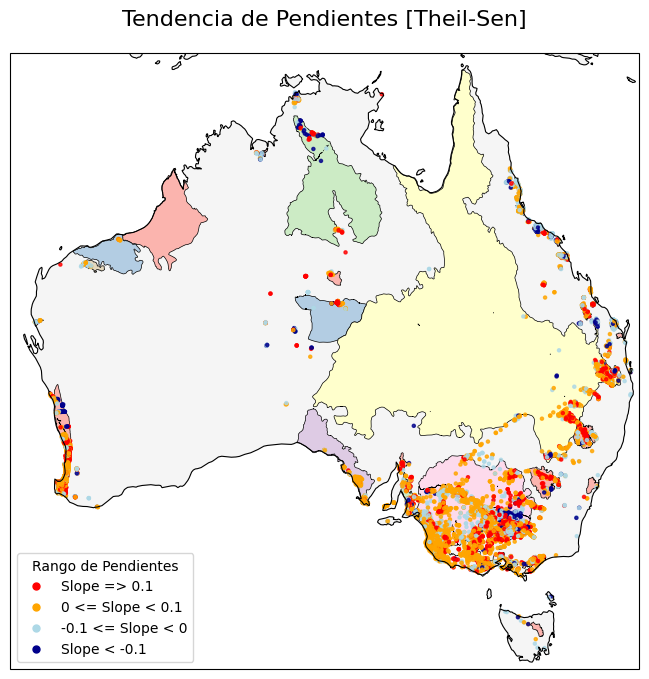

In [13]:
def vis_pozos(shp_path, npz_paths, output_path):
    # Cargar datos de acuíferos
    mapa = gpd.read_file(shp_path).to_crs(epsg=4326)
    
    # Disolver geometrías por cuenca
    cuencas_unificadas = mapa.dissolve(by='Broader')
    
    # Configuración de colores Pastel1 para las cuencas
    unique_regions = cuencas_unificadas.index.unique()
    cmap = plt.get_cmap('Pastel1')
    region_colors = {region: cmap(i % cmap.N) for i, region in enumerate(unique_regions)}

    all_lon, all_lat, all_slope = [], [], []

    # Procesar archivos .npz
    for npz_path in npz_paths:
        pozos = np.load(npz_path)
        mask = pozos['dtw_condyr'] == 1
        lon = pozos['lon'][mask]
        lat = pozos['lat'][mask]
        slope = pozos['dtw_slop_t'][mask]

        valid_mask = (slope > -0.5) & (slope < 0.5)
        all_lon.append(lon[valid_mask])
        all_lat.append(lat[valid_mask])
        all_slope.append(slope[valid_mask])

    lon = np.concatenate(all_lon)
    lat = np.concatenate(all_lat)
    slope = np.concatenate(all_slope)

    # Configuración del gráfico
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([112, 154, -44, -10], crs=ccrs.PlateCarree())
    
    # Fondo del mapa
    ax.add_feature(cfeature.LAND, facecolor='whitesmoke')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    # Dibujar cuencas con relleno Pastel1 y bordes delgados (0.5)
    for region in cuencas_unificadas.index:
        cuencas_unificadas[cuencas_unificadas.index == region].plot(
            ax=ax,
            color=region_colors[region],
            edgecolor='black',
            linewidth=0.5,  # Línea delgada
            transform=ccrs.PlateCarree()
        )

    # Graficar pozos
    slope_colors = np.select(
        [slope < -0.1, (slope >= -0.1) & (slope < 0), (slope >= 0) & (slope < 0.1), slope >= 0.1],
        ['darkblue', 'lightblue', 'orange', 'red']
    )
    ax.scatter(lon, lat, c=slope_colors, s=5, alpha=0.8, transform=ccrs.PlateCarree())

    # Título
    ax.set_title('Tendencia de Pendientes [Theil-Sen]', fontsize=16, pad=20)
    
    # LEYENDA DE PENDIENTES (EXACTAMENTE COMO QUIERES)
    custom_legend = [
        Line2D([0], [0], color='red', marker='.', linestyle='None', markersize=10, label='Slope => 0.1'),
        Line2D([0], [0], color='orange', marker='.', linestyle='None', markersize=10, label='0 <= Slope < 0.1'),
        Line2D([0], [0], color='lightblue', marker='.', linestyle='None', markersize=10, label='-0.1 <= Slope < 0'),
        Line2D([0], [0], color='darkblue', marker='.', linestyle='None', markersize=10, label='Slope < -0.1')
    ]
    ax.legend(handles=custom_legend, loc='lower left', fontsize=10, title="Rango de Pendientes")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

output_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\mapas\mapa_pendientes_theilsen.png'
vis_pozos(shp_path, npz_paths, output_path)

In [14]:
rangos = [
    ("Pendiente muy negativa", -np.inf, -0.1),       # slope < -0.1
    ("Pendiente ligeramente negativa", -0.1, 0),     # -0.1 <= slope < 0
    ("Pendiente ligeramente positiva", 0, 0.1),      # 0 <= slope < 0.1
    ("Pendiente muy positiva", 0.1, np.inf)          # slope >= 0.1
]

# Contar valores en cada rango
conteo_rangos = {}
for nombre, min_val, max_val in rangos:
    if min_val == -np.inf:
        mask = (dtw_slop_t < max_val)
    elif max_val == np.inf:
        mask = (dtw_slop_t >= min_val)
    else:
        mask = (dtw_slop_t >= min_val) & (dtw_slop_t < max_val)
    conteo_rangos[nombre] = np.sum(mask)

# Calcular porcentajes (excluyendo NaN si existen)
total_validos = len(dtw_slop_t) - np.isnan(dtw_slop_t).sum()
porcentajes = {nombre: (count / total_validos) * 100 for nombre, count in conteo_rangos.items()}

# Resultados
print("----- Distribución de pendientes en rangos -----")
for nombre, count in conteo_rangos.items():
    print(f"{nombre}: {count} pozos ({porcentajes[nombre]:.2f}%)")

# Verificar datos faltantes (NaN)
nan_count = np.isnan(dtw_slop_t).sum()
if nan_count > 0:
    print(f"\n¡Advertencia: {nan_count} pozos tienen pendientes NaN (no incluidos en los cálculos)!")

----- Distribución de pendientes en rangos -----
Pendiente muy negativa: 141 pozos (8.15%)
Pendiente ligeramente negativa: 297 pozos (17.16%)
Pendiente ligeramente positiva: 713 pozos (41.19%)
Pendiente muy positiva: 580 pozos (33.51%)

¡Advertencia: 1063 pozos tienen pendientes NaN (no incluidos en los cálculos)!
